In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS, FREQUENCY_COLOR_MAPPINGS
import clustering as clstr
import bout.assembly as bt
import bout.clustering as clstr
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline

from cli import get_file_paths

In [4]:
site_key = 'Foliage'

In [5]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
files_from_loc

[PosixPath('../data/audiomoth_recordings/recover-20210912/Foliage/20210910_030000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220804/Foliage/20220802_030000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220804/Foliage/20220802_033000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220804/Foliage/20220802_040000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220804/Foliage/20220802_043000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220804/Foliage/20220802_050000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220804/Foliage/20220802_053000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220804/Foliage/20220802_060000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220804/Foliage/20220802_063000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220804/Foliage/20220802_070000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220804/Foliage/20220802_073000.WAV'),
 PosixPath('../data/a

In [6]:
pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '30of30'
data_params['bin_size'] = '30'
data_params['detector_tag'] = 'bd2'
data_params['use_thresholds'] = False
data_params['use_kmeans'] = True
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["detector_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
location_df['file_name'] = pd.DatetimeIndex(pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S.WAV', exact=False)).strftime('%Y%m%d_%H%M%S.WAV')

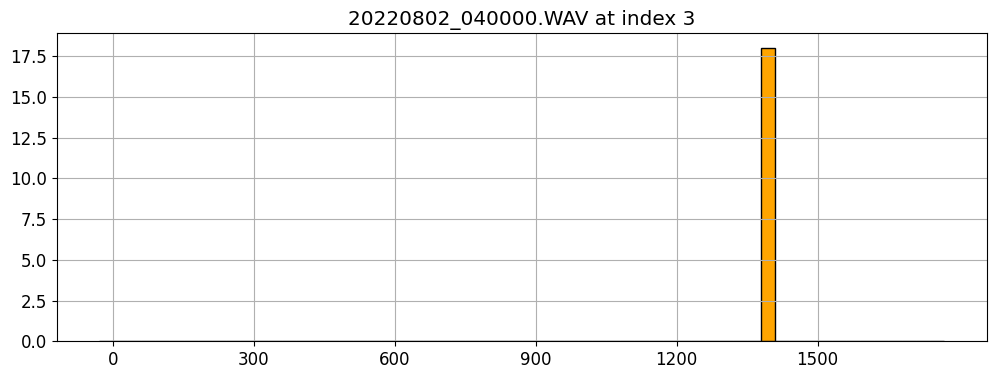

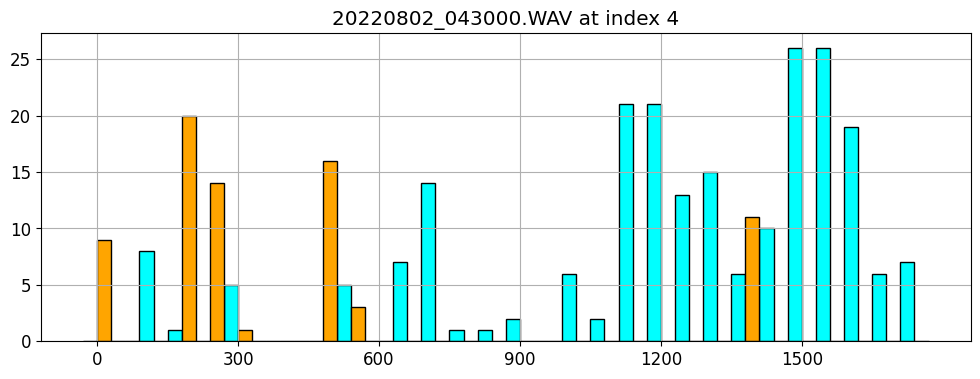

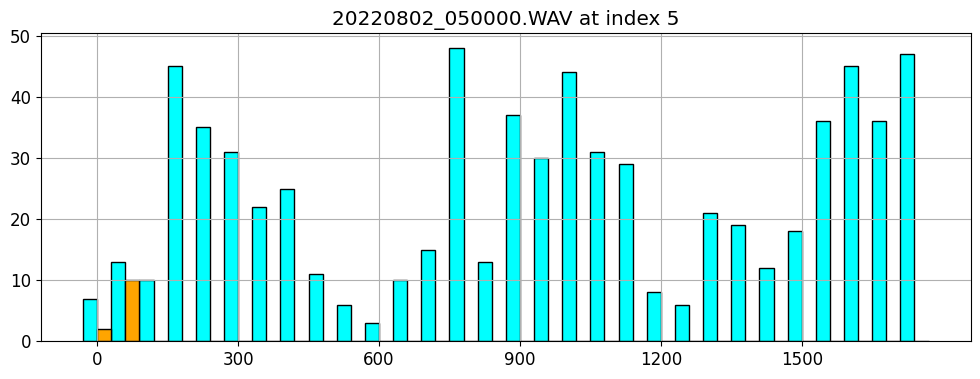

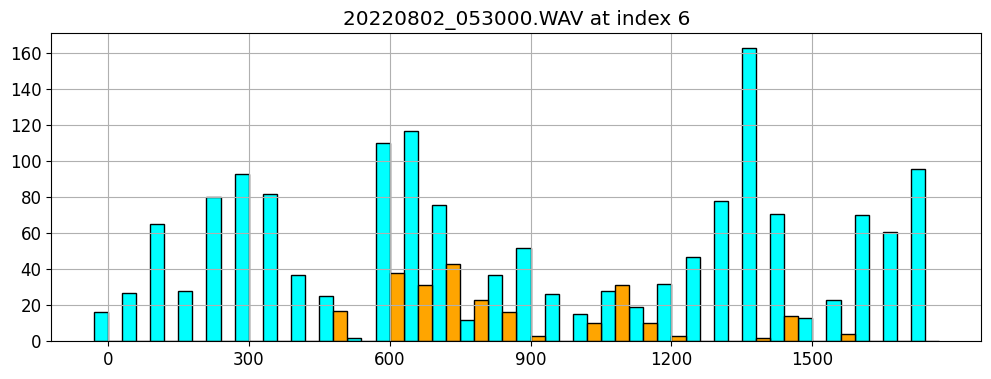

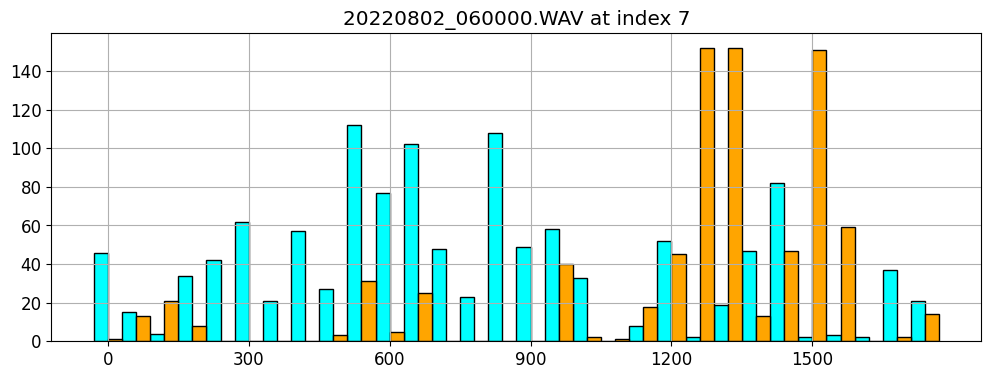

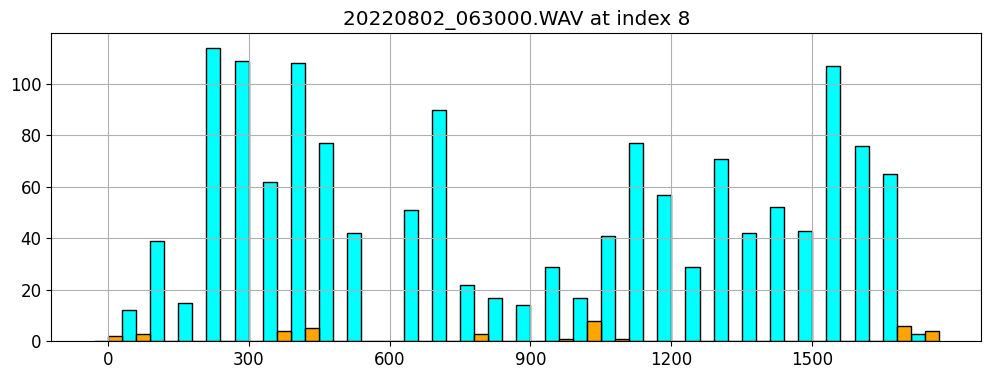

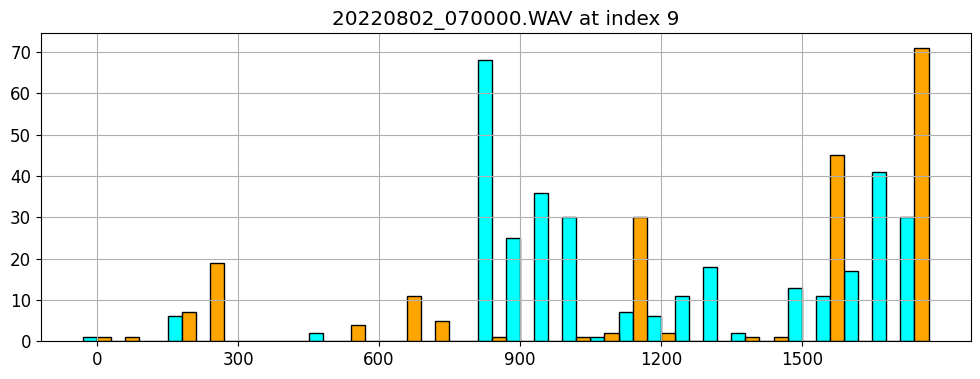

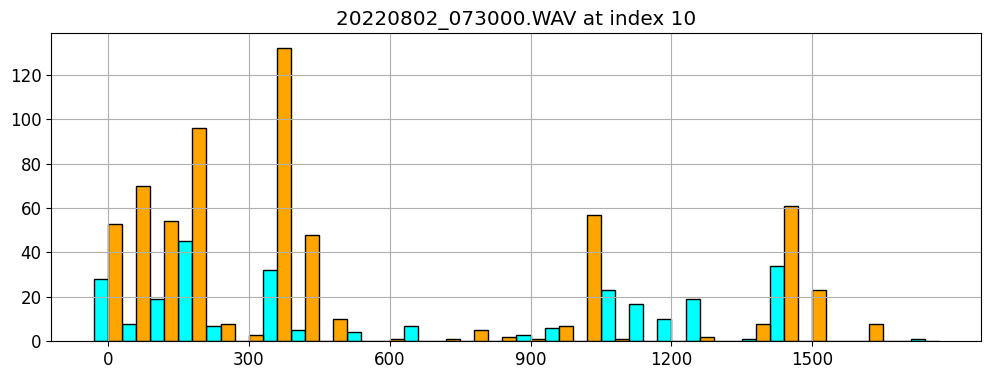

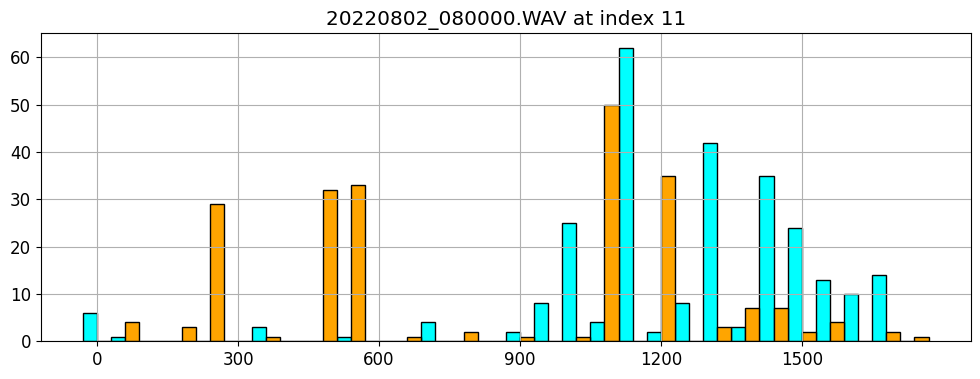

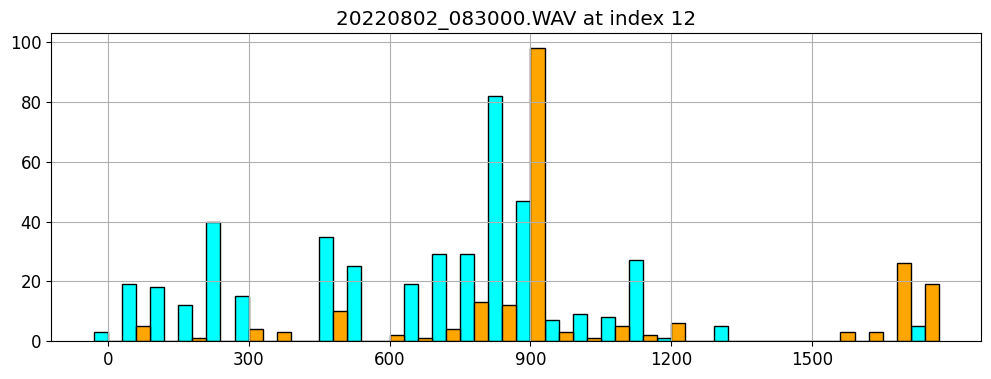

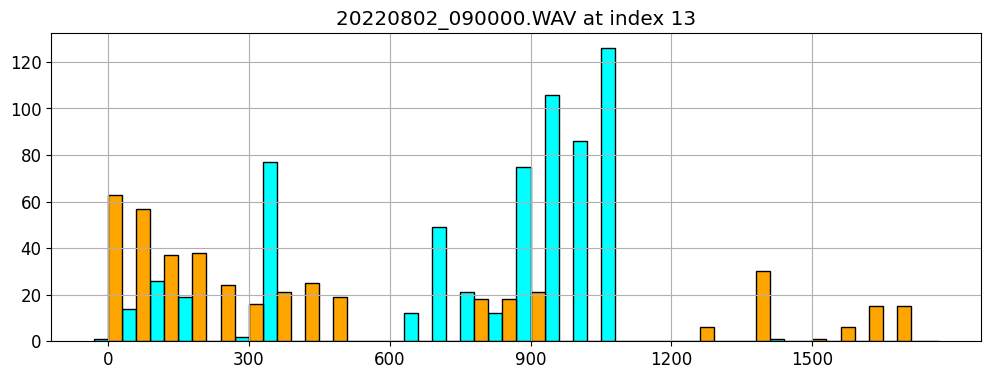

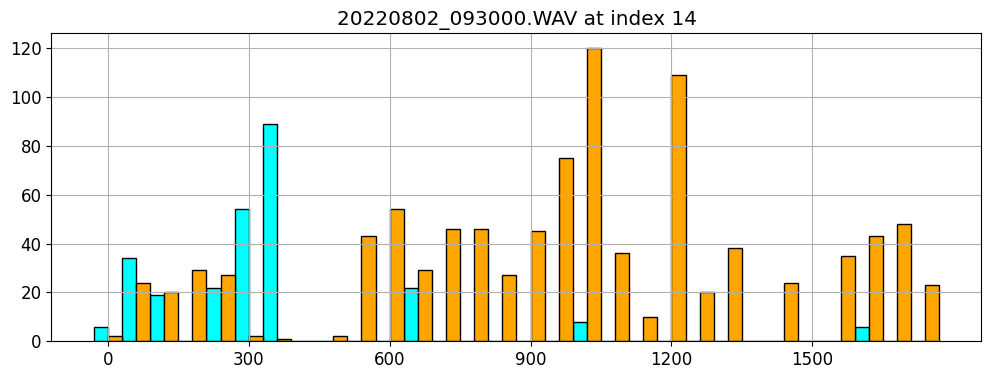

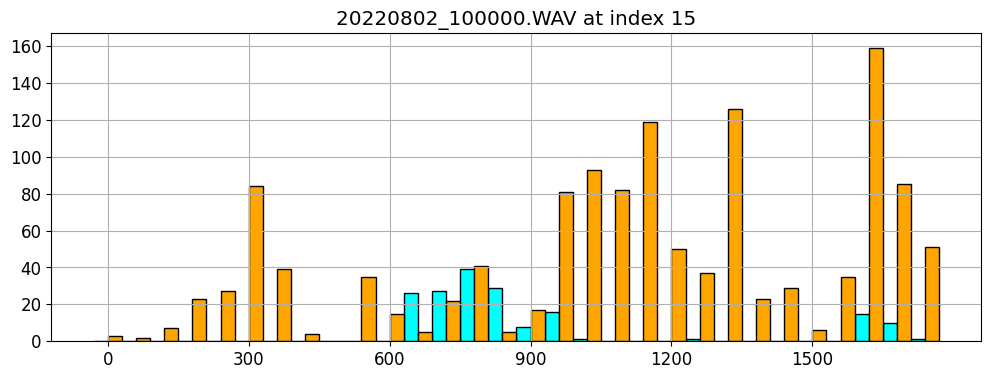

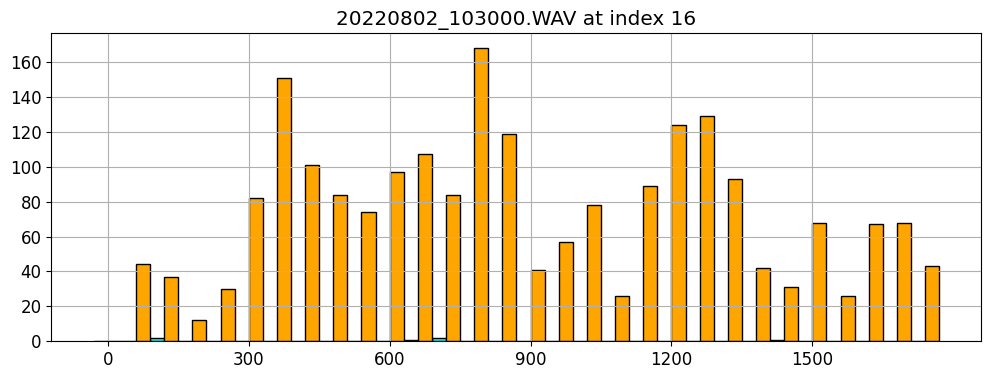

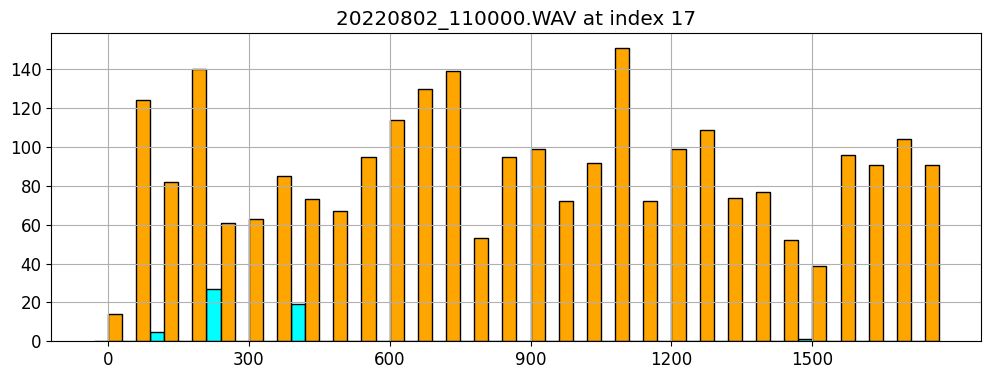

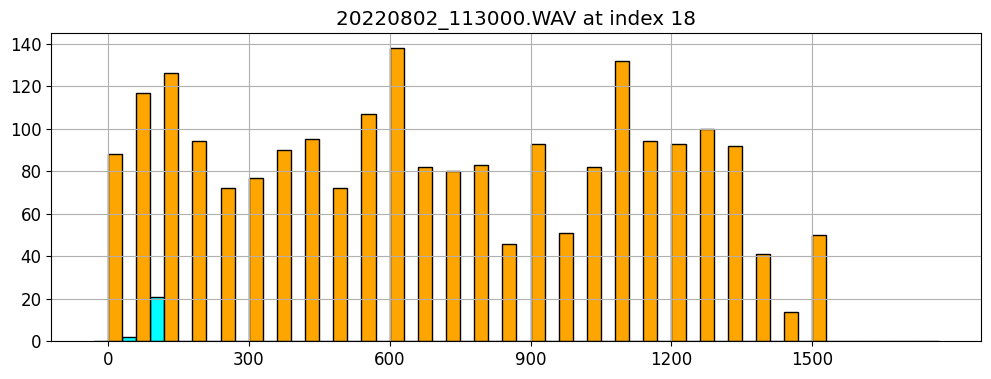

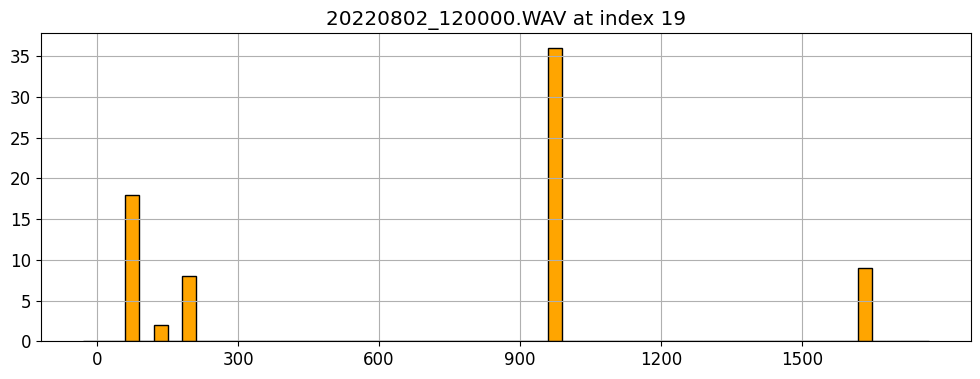

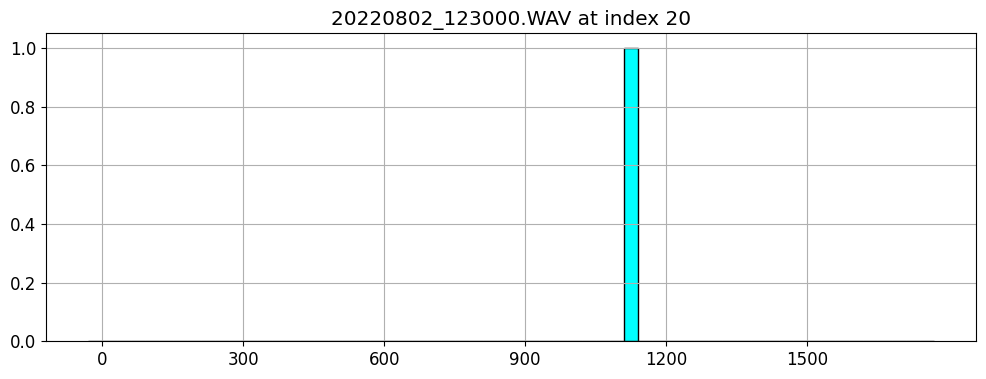

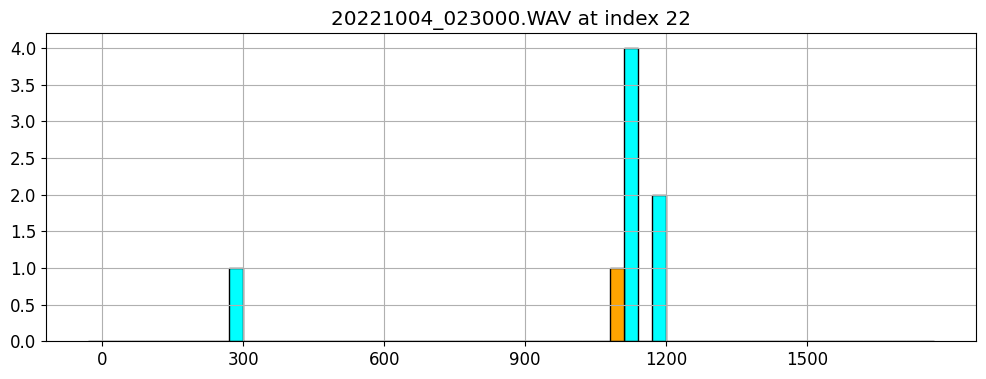

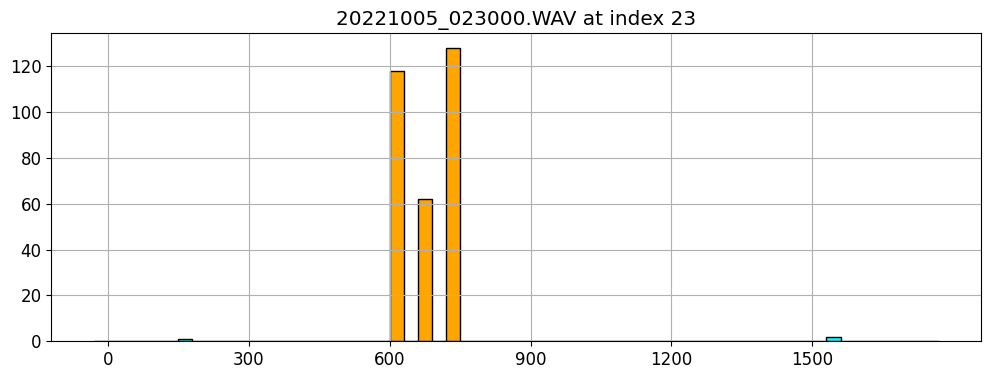

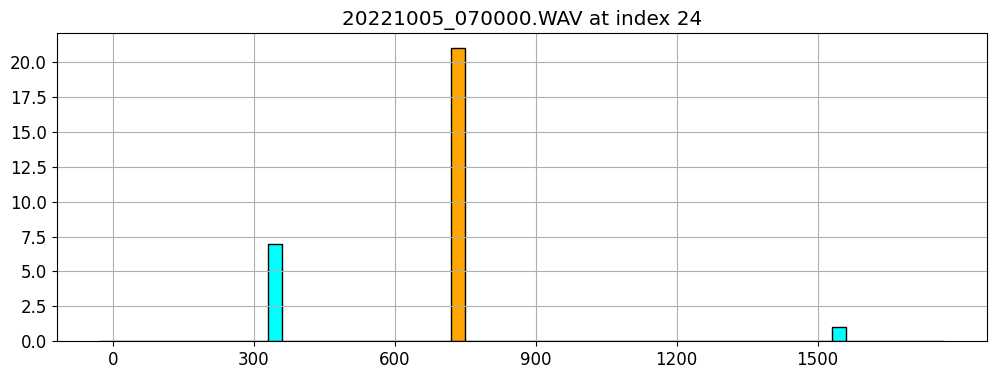

In [7]:
for i, file in enumerate(files_from_loc):
    file_path = Path(file)
    filename = file_path.name
    file_dets = location_df.loc[location_df['file_name']==filename].copy()
    if len(file_dets)>0:
        plt.figure(figsize=(12,4))
        plt.rcParams.update({'font.size':12})
        plt.title(f'{filename} at index {i}')

        shift = 15
        for group in ['LF', 'HF']:
            group_dets = file_dets[file_dets['freq_group']==group]
            counts, times = np.histogram(group_dets['start_time'].values, bins=np.arange(0, 1860, 60))
            plt.bar(x=times[:-1]-shift, height=counts, width=30, facecolor=FREQUENCY_COLOR_MAPPINGS[group], edgecolor='k')
            shift = -1 * shift

        plt.xticks(np.arange(0, 1800, 300))
        plt.grid(which='both')
        plt.show()

In [19]:
def get_bout_params_from_location(location_sum_df, data_params):
    """
    Given a location summary and the location it corresponds to, calculate the BCIs for each frequency group in the summary
    """

    bout_params = dict()
    bout_params['site_key'] = data_params['site_tag']

    for group in location_sum_df['freq_group'].unique():
        if group != '':
            freq_group_df = location_sum_df.loc[location_sum_df['freq_group']==group].copy()
            if not(freq_group_df.empty):
                ipis_loc, hist_loc = clstr.get_histogram(freq_group_df, 10)
                intervals_ms, survival = clstr.get_log_survival(hist_loc)
                fast_process = clstr.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
                fast_process = clstr.calculate_exponential_coefficients(fast_process)
                slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
                slow_process = clstr.calculate_exponential_coefficients(slow_process)
                bci, misassigned_points_optim = clstr.get_bci_from_slater_method(intervals_ms, survival, fast_process, slow_process)
                bout_params[f'{group}_bci'] = bci

    return bout_params

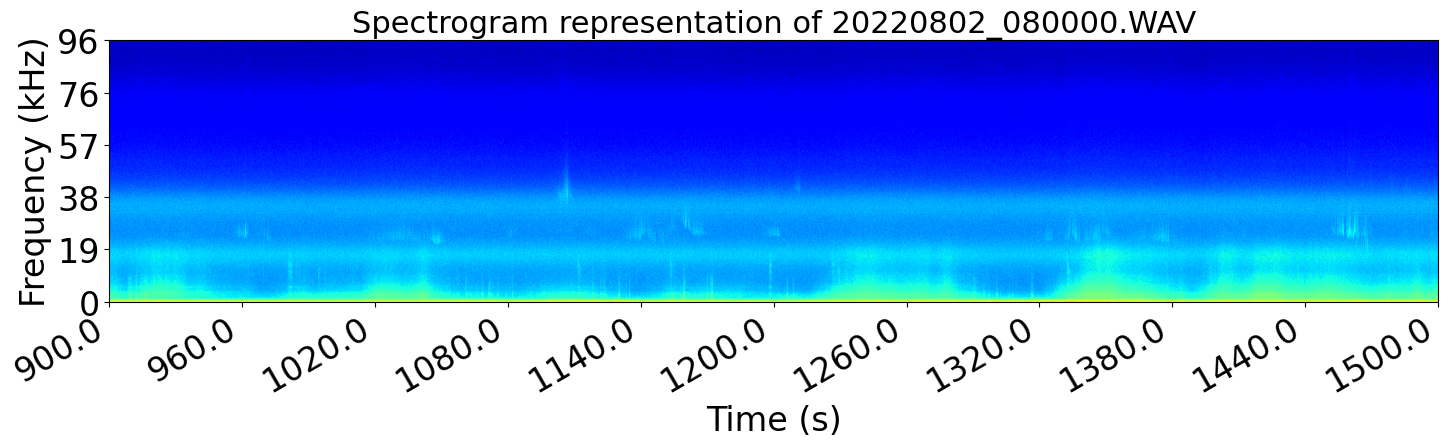

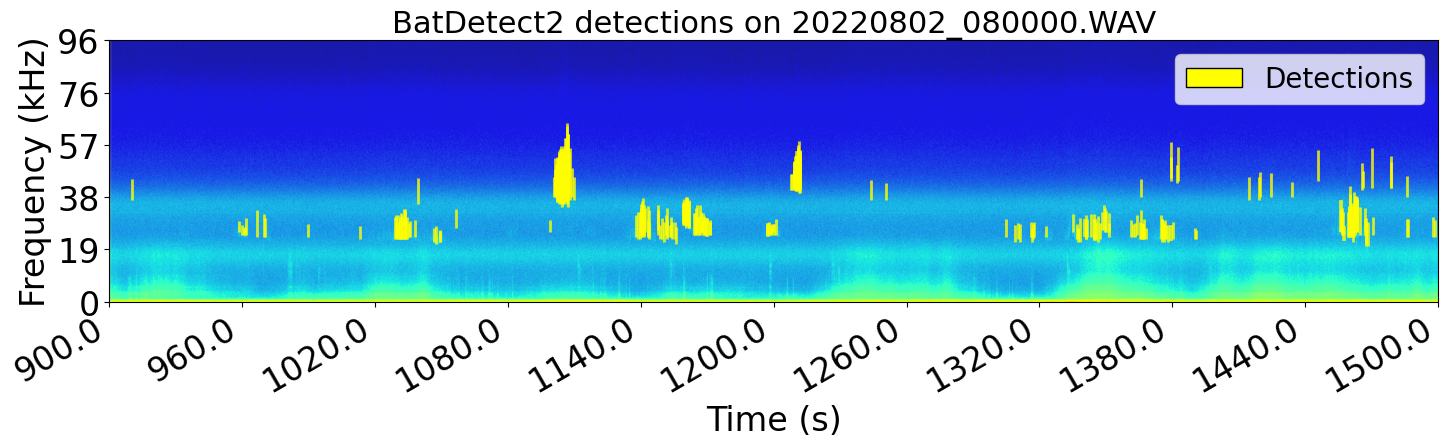

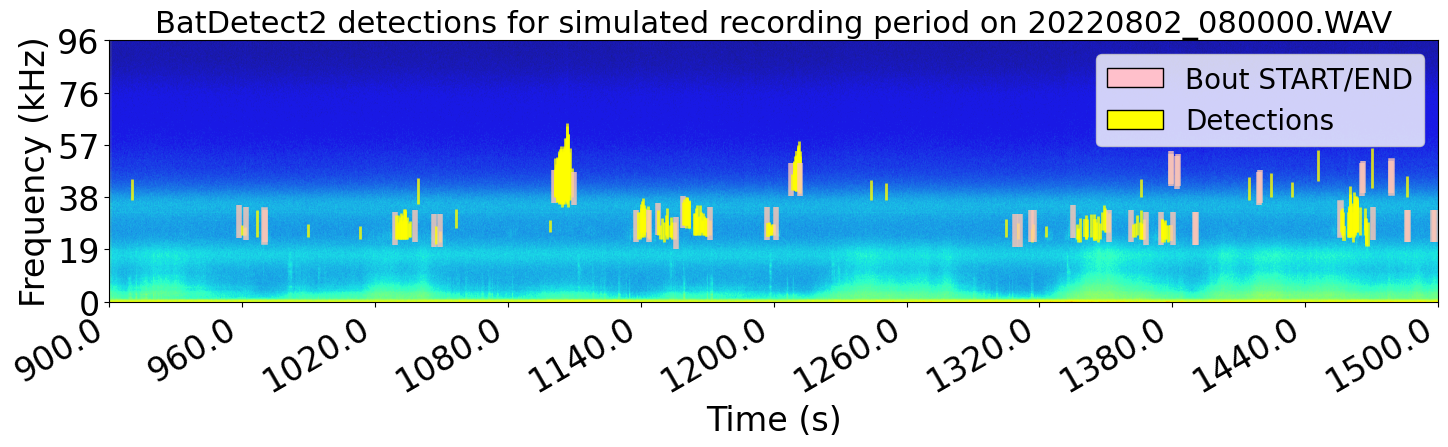

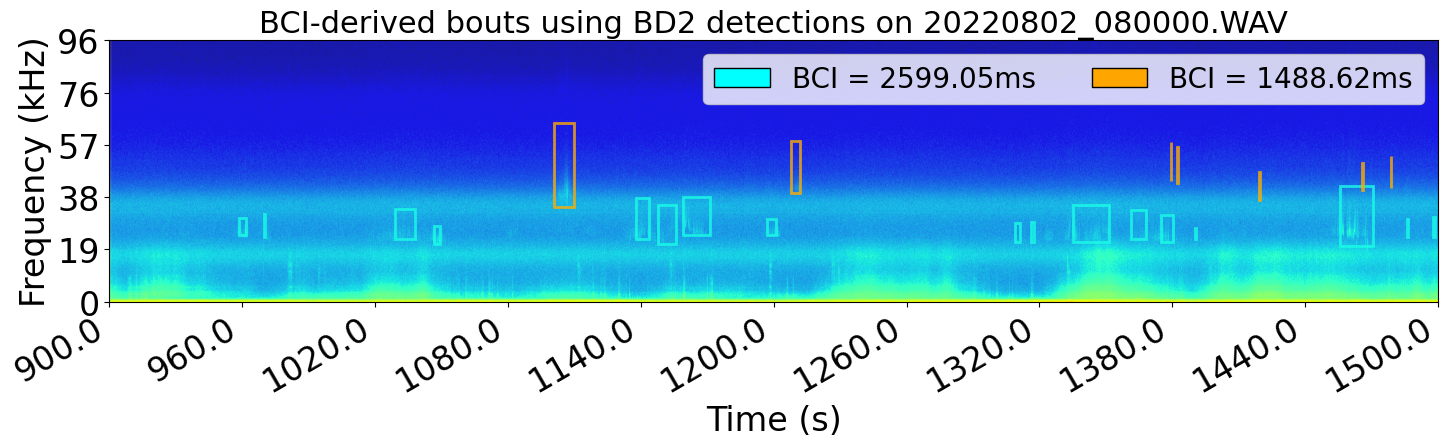

In [20]:
for ind in [11]:
    file_path = Path(files_from_loc[ind])
    filename = file_path.name
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate
    start = 900
    duration = 600
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB

    audio_features = dict()
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration

    spec_features = dict()
    spec_features['vmin'] = vmin
    spec_features['NFFT'] = 1024
    spec_features['cmap'] = 'jet'

    file_dets = location_df.loc[location_df['file_name']==filename].copy()
    plot_dets_no_dutycycle = file_dets.loc[np.logical_and(file_dets['start_time'] > start, file_dets['end_time'] < (start+duration))]
    batdetect2_predictions = ss.simulate_dutycycle_on_detections_with_bins(file_dets, data_params['cur_dc_tag'], data_params['bin_size'])
    bout_params = get_bout_params_from_location(location_df, data_params)

    batdetect2_preds_with_bouttags = bt.classify_bouts_in_detector_preds_for_freqgroups(batdetect2_predictions, bout_params)
    plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
    bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
    plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

    bt_plt.plot_audio_seg(audio_features, spec_features)
    bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle, data_params)
    bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
    bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts)

In [21]:
def get_bout_params_from_location(location_sum_df, data_params):
    """
    Given a location summary and the location it corresponds to, calculate the BCIs for each frequency group in the summary
    """

    bout_params = dict()
    bout_params['site_key'] = data_params['site_tag']

    for group in location_sum_df['freq_group'].unique():
        if group != '':
            freq_group_df = location_sum_df.loc[location_sum_df['freq_group']==group].copy()
            if not(freq_group_df.empty):
                ipis_loc, hist_loc = clstr.get_histogram(freq_group_df, 10)
                intervals_ms, survival = clstr.get_log_survival(hist_loc)
                fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
                fast_process = clstr.calculate_exponential_coefficients(fast_process)
                slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
                slow_process = clstr.calculate_exponential_coefficients(slow_process)
                bci, misassigned_points = clstr.get_bci_from_slater_method(intervals_ms, survival, fast_process, slow_process)
                bout_params[f'{group}_bci'] = bci
                
    return bout_params

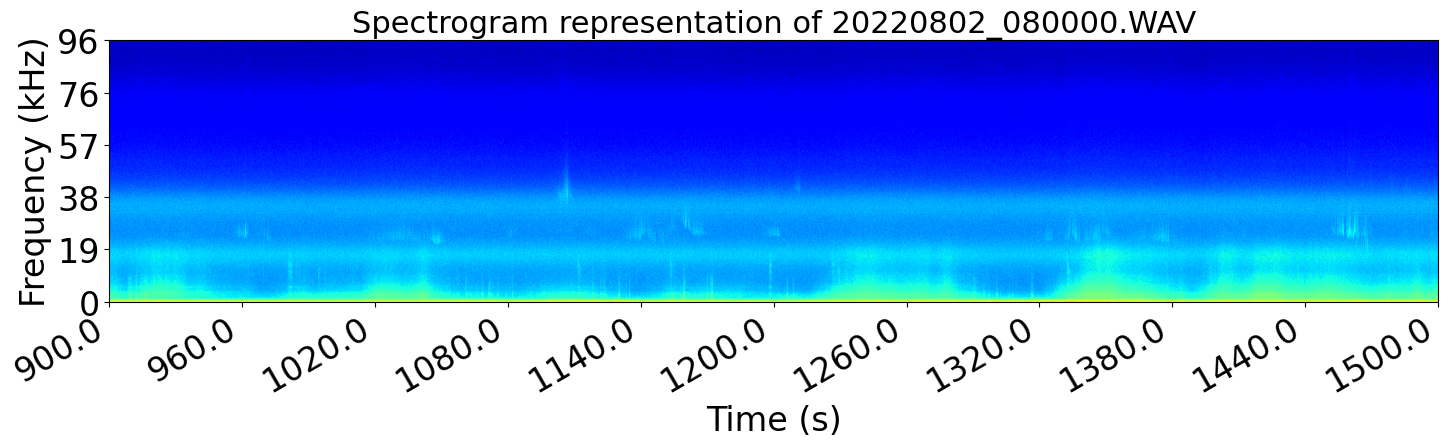

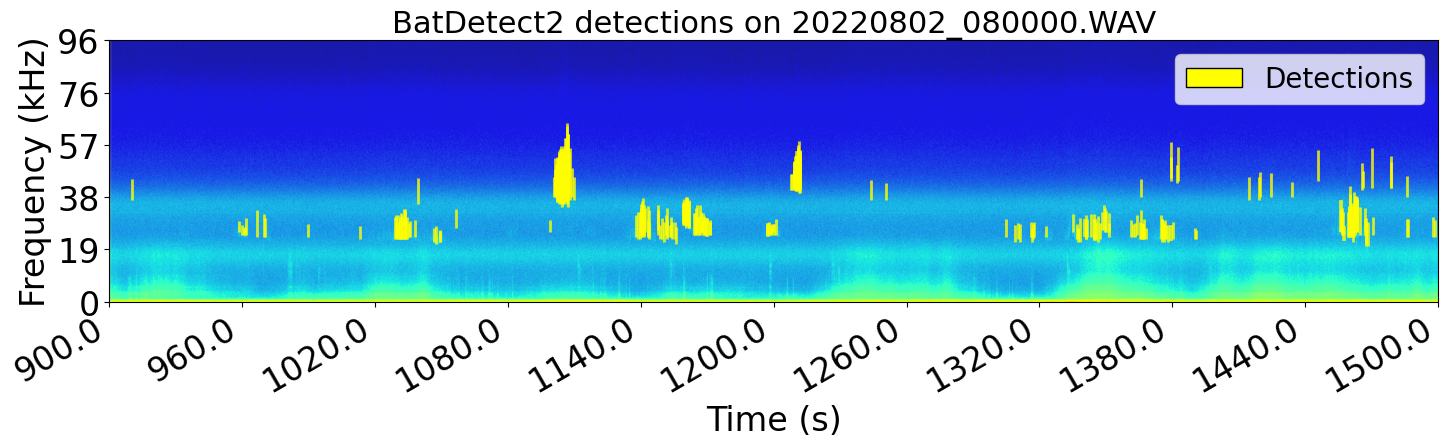

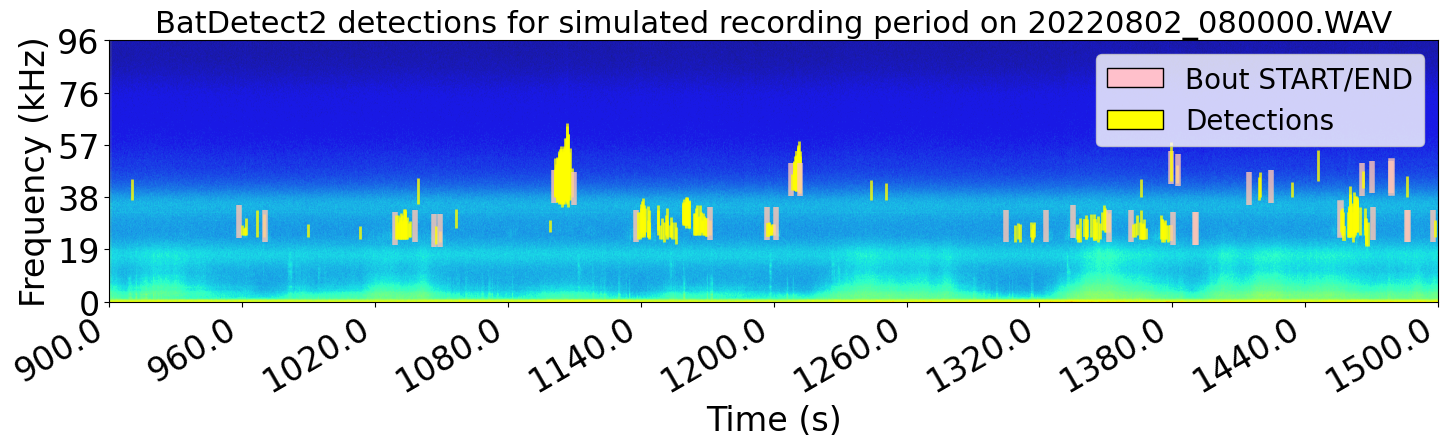

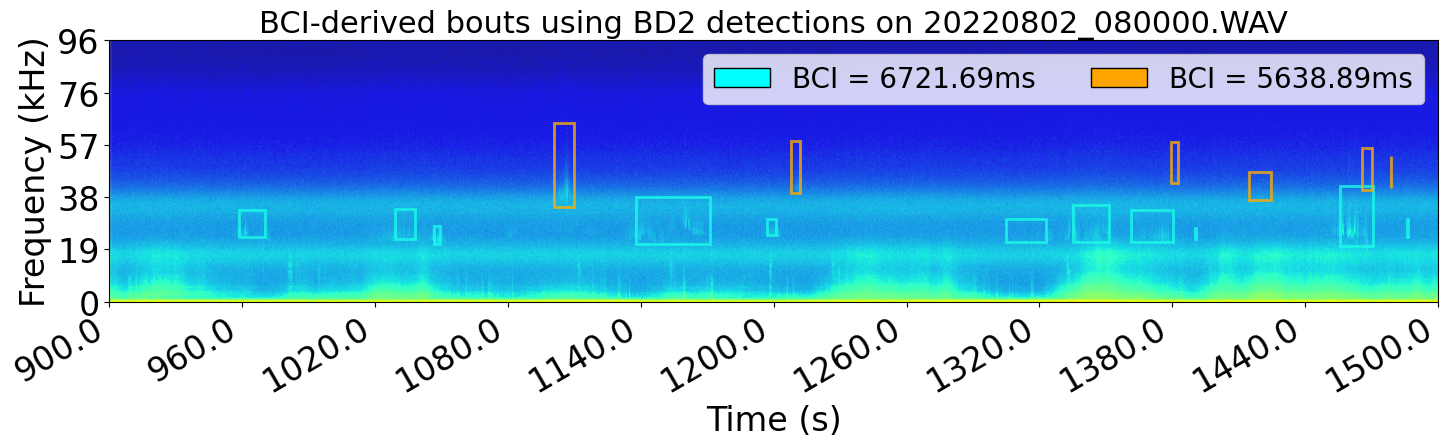

In [23]:
for ind in [11]:
    file_path = Path(files_from_loc[ind])
    filename = file_path.name
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate
    start = 900
    duration = 600
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB

    audio_features = dict()
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration

    spec_features = dict()
    spec_features['vmin'] = vmin
    spec_features['NFFT'] = 1024
    spec_features['cmap'] = 'jet'

    file_dets = location_df.loc[location_df['file_name']==filename].copy()
    plot_dets_no_dutycycle = file_dets.loc[np.logical_and(file_dets['start_time'] > start, file_dets['end_time'] < (start+duration))]
    batdetect2_predictions = ss.simulate_dutycycle_on_detections_with_bins(file_dets, data_params['cur_dc_tag'], data_params['bin_size'])
    bout_params = get_bout_params_from_location(location_df, data_params)

    batdetect2_preds_with_bouttags = bt.classify_bouts_in_detector_preds_for_freqgroups(batdetect2_predictions, bout_params)
    plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
    bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
    plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

    bt_plt.plot_audio_seg(audio_features, spec_features)
    bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle, data_params)
    bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
    bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts)

In [24]:
def get_bout_params_from_location(location_sum_df, data_params):
    """
    Given a location summary and the location it corresponds to, calculate the BCIs for each frequency group in the summary
    """

    bout_params = dict()
    bout_params['site_key'] = data_params['site_tag']

    for group in location_sum_df['freq_group'].unique():
        if group != '':
            freq_group_df = location_sum_df.loc[location_sum_df['freq_group']==group].copy()
            if not(freq_group_df.empty):
                ipis_loc, hist_loc = clstr.get_histogram(freq_group_df, 10)
                intervals_ms, survival = clstr.get_log_survival(hist_loc)
                fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
                fast_process = clstr.calculate_exponential_coefficients(fast_process)
                slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
                slow_process = clstr.calculate_exponential_coefficients(slow_process)
                nlin_results, misassigned_points = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
                bout_params[f'{group}_bci'] = nlin_results['bci']
                
    return bout_params

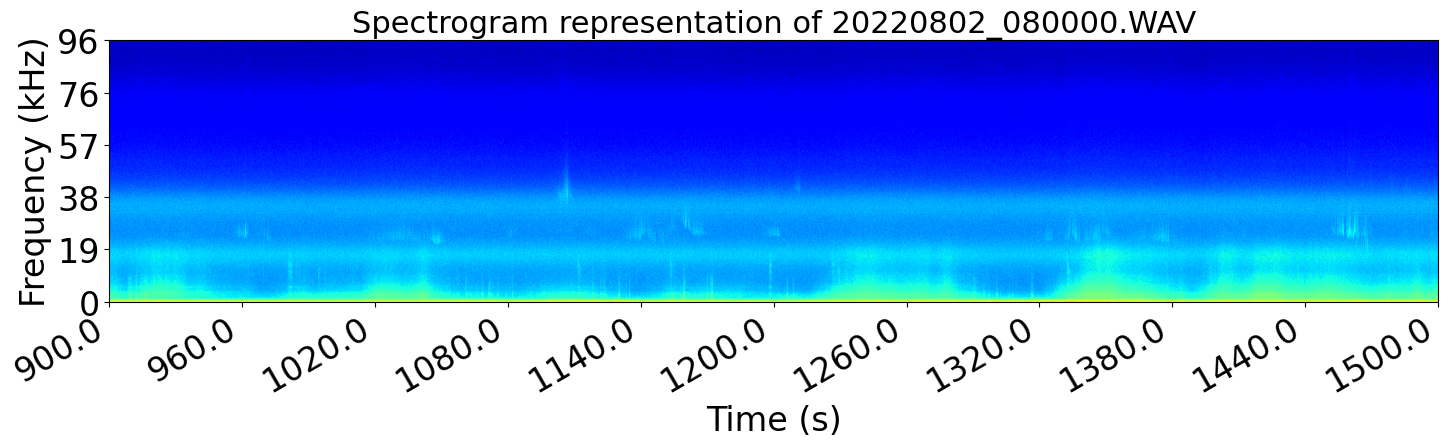

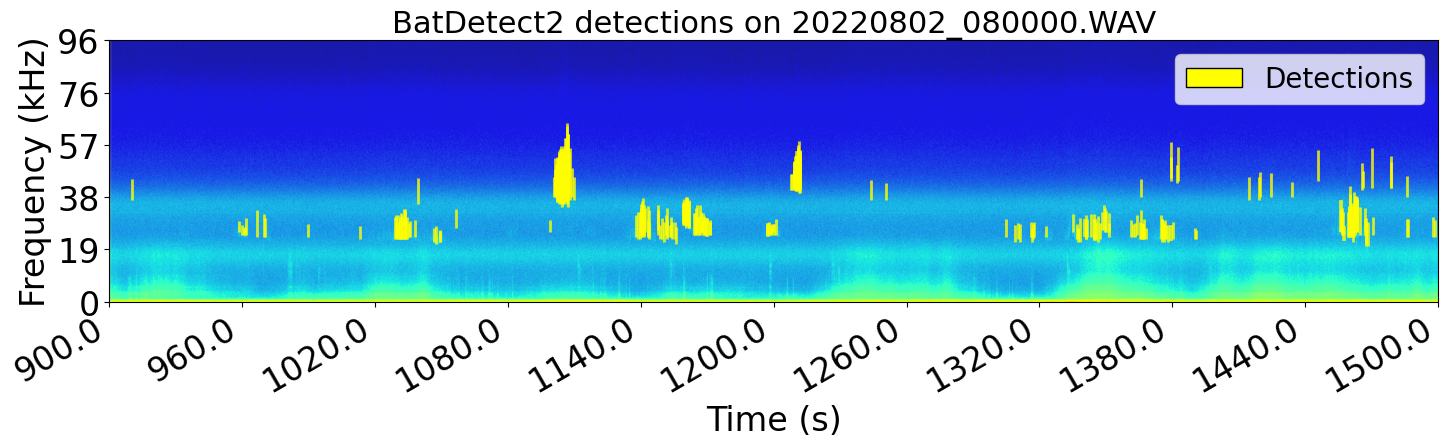

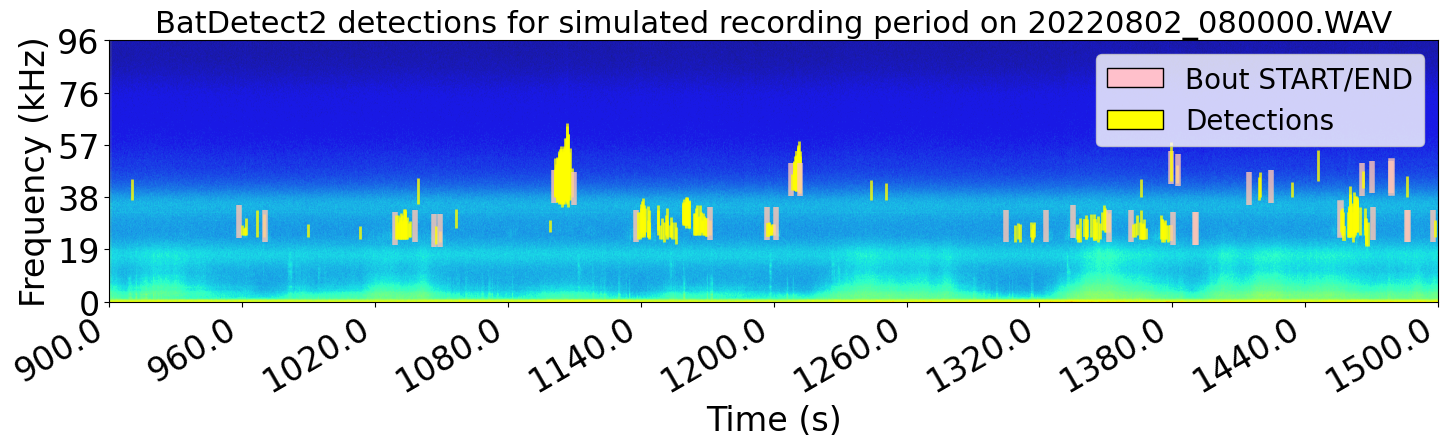

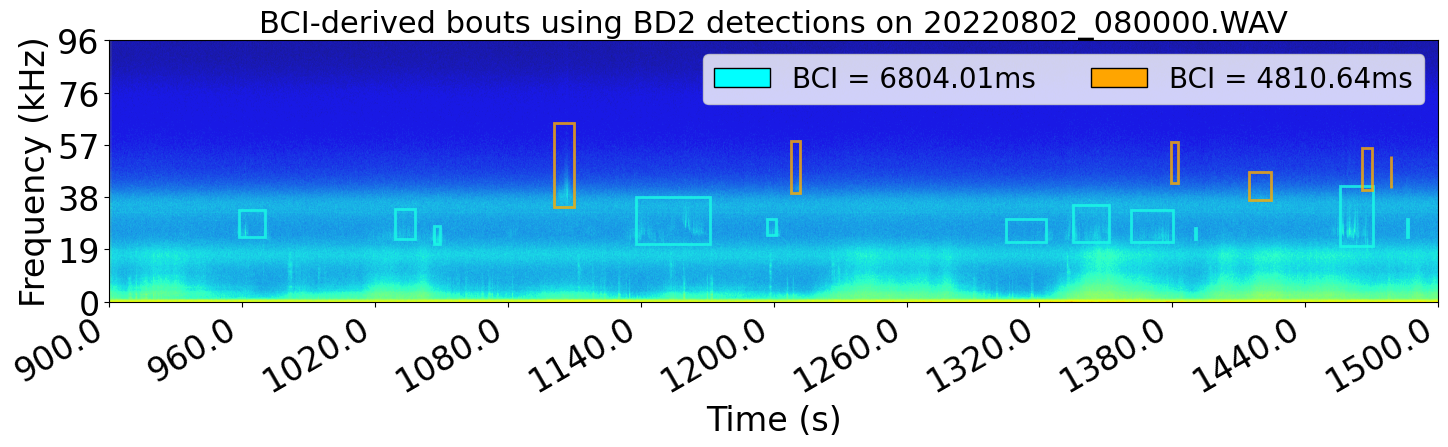

In [13]:
for ind in [11]:
    file_path = Path(files_from_loc[ind])
    filename = file_path.name
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate
    start = 900
    duration = 600
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))
    vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB

    audio_features = dict()
    audio_features['file_path'] = file_path
    audio_features['audio_seg'] = audio_seg
    audio_features['sample_rate'] = fs
    audio_features['start'] = start
    audio_features['duration'] = duration

    spec_features = dict()
    spec_features['vmin'] = vmin
    spec_features['NFFT'] = 1024
    spec_features['cmap'] = 'jet'

    file_dets = location_df.loc[location_df['file_name']==filename].copy()
    plot_dets_no_dutycycle = file_dets.loc[np.logical_and(file_dets['start_time'] > start, file_dets['end_time'] < (start+duration))]
    batdetect2_predictions = ss.simulate_dutycycle_on_detections_with_bins(file_dets, data_params['cur_dc_tag'], data_params['bin_size'])
    bout_params = get_bout_params_from_location(location_df, data_params)

    batdetect2_preds_with_bouttags = bt.classify_bouts_in_detector_preds_for_freqgroups(batdetect2_predictions, bout_params)
    plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
    bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
    plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

    bt_plt.plot_audio_seg(audio_features, spec_features)
    bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle, data_params)
    bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
    bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts)